<p style="text-align: center;font-size: 24px;">Отчет по лабораторной работе №8<br>
по курсу «Численные методы»</p>

Студент группы М8О-406Б-19: Суханов Е.А.\
Преподаватель: Пивоваров Д.Е.\
Отчет сдан:\
Итоговая оценка:\
Подпись преподавателя:

---

##### 1. Тема работы
МЕТОД КОНЕЧНЫХ РАЗНОСТЕЙ РЕШЕНИЯ МНОГОМЕРНЫХ ЗАДАЧ
МАТЕМАТИЧЕСКОЙ ФИЗИКИ. МЕТОДЫ РАСЩЕПЛЕНИЯ.

---

##### 2. Цель работы

**Задание**: Используя схемы переменных направлений и дробных шагов, решить двумерную начально-краевую задачу для дифференциального уравнения параболического типа. В различные моменты времени вычислить погрешность численного решения путем сравнения результатов с приведенным в задании аналитическим решением . Исследовать зависимость погрешности от сеточных параметров.

**Вариант**: 7

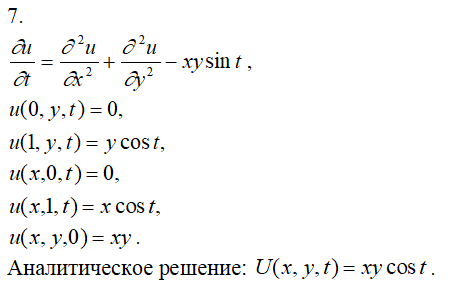

---

##### 3. Ход работы

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Task():
    def __init__(self, ulx, urx, uly, ury, u0, a, b, c, d, f, x0, x1, y0, y1):
        self.ulx = ulx
        self.urx = urx
        self.uly = uly
        self.ury = ury
        self.u0 = u0
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.f = f

        self.x0 = x0
        self.x1 = x1
        self.y0 = y0
        self.y1 = y1
# Вариант 7
task = Task(
    ulx = lambda y,t: 0,
    urx = lambda y,t: y*np.cos(t),
    uly = lambda x,t: 0,
    ury = lambda x,t: x * np.cos(t),
    u0 = lambda x,y: x * y,
    a = 1,
    b = 1,
    c = 0,
    d = 0,
    f = lambda x,y,t: -x*y*np.sin(t),

    x0 = 0,
    x1 = 1,
    y0 = 0,
    y1 = 1,
)

analytic_func = lambda x,y,t: x*y*np.cos(t)

X_RES = 40
Y_RES = 40
T_RES = 100
END_TIME = 10

In [3]:
# Аналитическое решение
def analytic(x_0, x_1, y_0, y_1, end_time, func, x_res, y_res, t_res):
    x = (x_1 - x_0) / (x_res-1)
    y = (y_1 - y_0) / (y_res-1)
    t = (end_time) / (t_res-1)
    u = np.zeros(shape=(t_res, y_res, x_res))

    for k in range(0, t_res):
        _t = t * k
        for j in range(0, y_res):
            _y = y_0 + j * y
            for i in range(0, x_res):
                _x = x_0 + i * x
                u[k][j][i] = func(_x, _y, _t)
    return u

In [4]:
def tridiagonal_matrix_algorithm(a, b, c, d):
    n = len(a)

    p = np.zeros(n)
    q = np.zeros(n)

    p[0] = -c[0] / b[0]
    q[0] = d[0] / b[0]

    for i in range(1, n):
        p[i] = -c[i] / (b[i] + a[i] * p[i - 1])
        q[i] = (d[i] - a[i] * q[i - 1]) / (b[i] + a[i] * p[i - 1])

    x = np.zeros(n)
    x[-1] = q[-1]

    for i in range(n - 2, -1, -1):
        x[i] = p[i] * x[i + 1] + q[i]

    return x

# Метод переменных направлений
def pdir(task: Task, x_res, y_res, t_res, end_time):
    x = (task.x1 - task.x0) / (x_res-1)
    y = (task.y1 - task.y0) / (y_res-1)
    tau = (end_time) / (t_res-1)

    u = np.zeros(shape=(t_res, y_res, x_res))
    # Заполнение первого слоя
    for j in range(0, y_res):
        _y = task.y0 + j * y
        for i in range(0, x_res):
            _x = task.x0 + i * x
            u[0][j][i] = task.u0(_x,_y)
    
    for k in range(1, t_res):
        # y
        _t = k * tau
        u1 = np.zeros(shape=(y_res, x_res))
        _t2 = _t - tau / 2
        for j in range(y_res - 1):
            _y = task.y0 + j * y

            a = np.zeros(x_res)
            b = np.zeros(x_res)
            c = np.zeros(x_res)
            d = np.zeros(x_res)
            
            a[0] = 0
            b[0] = x
            c[0] = 0
            d[0] = task.ulx(_y, _t2) * x

            a[-1] = 0
            b[-1] = x
            c[-1] = 0
            d[-1] = task.urx(_y, _t2) * x

            for i in range(x_res - 1):
                _x = task.x0 + i * x

                a[i] = task.a - x * task.c / 2
                b[i] = x ** 2 - 2 * (x ** 2) / tau - 2 * task.a
                c[i] = task.a + x * task.c / 2
                d[i] = -2 * (x ** 2) * u[k - 1][j][i] / tau
                - task.b * (x ** 2) * (u[k - 1][j + 1][i] - 2 * u[k - 1][j][i] + u[k-1][j-1][i]) / (y ** 2)
                - task.d * (x ** 2) * (u[k-1][j+1][i] - u[k-1][j-1][i]) / (2 * y ** 2)
                - (x ** 2) * task.f(_x, _y, _t)

            xx = tridiagonal_matrix_algorithm(a, b, c, d)
            for i in range(x_res):
                _x = task.x0 + i * x
                u1[j][i] = xx[i]
                u1[0][i] = task.uly(_x, _t2)
                u1[-1][i] = task.ury(_x, _t2)
        
        # x bounds
        for j in range(y_res):
            _y = task.y0 + j * y
            u1[j][0] = task.ulx(_y, _t2)
            u1[j][-1] = task.urx(_y, _t2)
        # x
        u2 = np.zeros((y_res, x_res))
        for i in range(x_res - 1):
            _x = task.x0 + i * x
            a = np.zeros(y_res)
            b = np.zeros(y_res)
            c = np.zeros(y_res)
            d = np.zeros(y_res)

            a[0] = 0
            b[0] = y
            c[0] = 0
            d[0] = task.uly(_x, _t) * y
            
            a[-1] = 0
            b[-1] = y
            c[-1] = 0
            d[-1] = task.ury(_x, _t) * y

            for j in range(y_res - 1):
                _y = task.y0 + j * y
                a[j] = task.b - y * task.d / 2
                b[j] = y ** 2 - 2 * (y ** 2) / tau - 2 * task.b
                c[j] = task.b + y * task.d / 2
                d[j] = -2 * (y ** 2) * u1[j][i] / tau
                - task.a * (y ** 2) * (u1[j][i + 1] - 2 * u1[j][i] + u1[j][i - 1]) / (x ** 2)
                - task.c * (y ** 2) * (u1[j][i + 1] - u1[j][i - 1]) / (2 * x ** 2)
                - (y ** 2) * task.f(_x, _y, _t)

            xx = tridiagonal_matrix_algorithm(a, b, c, d)
            for j in range(y_res):
                _y = task.y0 + j * y
                u2[j][i] = xx[j]
                u2[j][0] = task.ulx(_y, _t)
                u2[j][-1] = task.urx(_y, _t)
        
        # x bounds
        for i in range(x_res):
            _x = task.x0 + i * x
            u2[0][i] = task.uly(_x, _t)
            u2[-1][i] = task.ury(_x, _t)

        # copy
        for i in range(x_res):
            for j in range(y_res):
                u[k][j][i] = u2[j][i]
    
    return u

In [5]:
# Метод дробных шагов
def frac_steps(task: Task, x_res, y_res, t_res, end_time):
    x = (task.x1 - task.x0) / (x_res-1)
    y = (task.y1 - task.y0) / (y_res-1)
    tau = (end_time) / (t_res-1)

    u = np.zeros(shape=(t_res, y_res, x_res))
    # Заполнение первого слоя
    for j in range(0, y_res):
        _y = task.y0 + j * y
        for i in range(0, x_res):
            _x = task.x0 + i * x
            u[0][j][i] = task.u0(_x,_y)

    for k in range(t_res):
        _t = k * tau
        u1 = np.zeros((y_res, x_res))
        _t2 = _t - tau / 2
        for j in range(y_res - 1):
            _y = task.y0 + j * y

            a = np.zeros(x_res)
            b = np.zeros(x_res)
            c = np.zeros(x_res)
            d = np.zeros(x_res)
            
            a[0] = 0
            b[0] = x
            c[0] = 0
            d[0] = task.ulx(_y, _t2) * x

            a[-1] = 0
            b[-1] = x
            c[-1] = 0
            d[-1] = task.urx(_y, _t2) * x

            for i in range(x_res - 1):
                _x = task.x0 + i * x
                a[i] = task.a
                b[i] = -(x ** 2) / tau - 2 * task.a
                c[i] = task.a
                d[i] = -(x ** 2) * u[k - 1][j][i] / tau - (x ** 2) * task.f(_x, _y, _t2) / 2
            
            xx = tridiagonal_matrix_algorithm(a, b, c, d)
            for i in range(x_res):
                _x = task.x0 + i * x
                u1[j][i] = xx[i]
                u1[0][i] = task.uly(_x, _t2)
                u1[-1][i] = task.ury(_x, _t2)

        for j in range(y_res):
            _y = task.y0 + j * y
            u1[j][0] = task.ulx(_x, _t2)
            u1[j][-1] = task.urx(_x, _t2)

        u2 = np.zeros((y_res, x_res))
        for i in range(x_res - 1):
            _x = task.x0 + i * x
            a = np.zeros(y_res)
            b = np.zeros(y_res)
            c = np.zeros(y_res)
            d = np.zeros(y_res)

            a[0] = 0
            b[0] = y
            c[0] = 0
            d[0] = task.uly(_x, _t) * y
            
            a[-1] = 0
            b[-1] = y
            c[-1] = 0
            d[-1] = task.ury(_x, _t) * y

            for j in range(y_res - 1):
                _y = task.y0 + j * y
                a[j] = task.b
                b[j] = -(y ** 2) / tau - 2 * task.b
                c[j] = task.b
                d[j] = -(y ** 2) * u1[j][i] / tau - (y ** 2) * task.f(_x, _y, _t) / 2
            
            xx = tridiagonal_matrix_algorithm(a, b, c, d)
            for j in range(y_res):
                _y = task.y0 + j * y
                u2[j][i] = xx[j]
                u2[j][0] = task.ulx(_y, _t)
                u2[j][-1] = task.urx(_y, _t)
        
        for i in range(x_res):
            _x = task.x0 + i * x
            u2[0][i] = task.uly(_x, _t)
            u2[-1][i] = task.ury(_x, _t)

        for i in range(x_res):
            for j in range(y_res):
                u[k][j][i] = u2[j][i]
    return u

##### Сравнение методов

In [6]:
def draw(x0, x1, y0, y1, end_time, nodes, labels):
    fig = plt.figure(figsize = plt.figaspect(0.7))

    t_res, y_res, x_res = nodes[0].shape
    x = (x1 - x0) / (x_res-1)
    y = (y1 - y0) / (y_res-1)
    t = end_time / (t_res-1) 
    
    x = np.arange(x0, x1+x/2, x)
    y = np.arange(y0, y1+y/2, y)
    t = np.arange(0, end_time+t/2, t)

    for n,l in zip(nodes, labels):
        plt.plot(t, np.mean(n, axis=(1,2)), label = f'Линия уровня {l}')
    plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
    plt.title(f'Среднее значение сетки по оси t')
    plt.xlabel('t')
    plt.ylabel('err')
    plt.grid(True)
    plt.show()

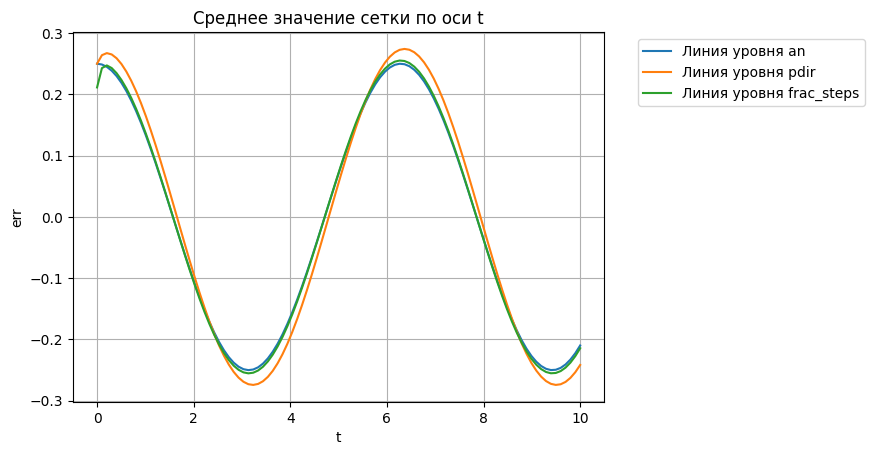

In [7]:
analytic_nodes = analytic(task.x0, task.x1, task.y0, task.y1, END_TIME, analytic_func, X_RES, Y_RES, T_RES)
pdir_nodes = pdir(task, X_RES, Y_RES, T_RES, END_TIME)
frac_steps_nodes = frac_steps(task, X_RES, Y_RES, T_RES, END_TIME)
draw(task.x0, task.x1, task.y0, task.y1, END_TIME, [analytic_nodes, pdir_nodes, frac_steps_nodes],['an', 'pdir', 'frac_steps'])


##### Сравнение погрешности методов

In [8]:
# Вывод графика ошибки
def draw_error(analytic, x0, x1, y0, y1, end_time, numericals, suffix_labels):
    t_res, y_res, x_res = analytic.shape
    x = (x1 - x0) / (x_res-1)
    y = (y1 - y0) / (y_res-1)
    t = end_time / (t_res-1) 
    x = np.arange(x0, x1+x/2, x)
    y = np.arange(y0, y1+y/2, y)
    t = np.arange(0, end_time+t/2, t)

    for n,l in zip(numericals, suffix_labels):
        err = np.mean(np.abs(analytic - n), axis=(1,2))
        plt.plot(t, err, label = f'Ошибка {l}')
    plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
    plt.title('График изменения ошибки по координате t')
    plt.xlabel('t')
    plt.ylabel('error')
    plt.grid(True)
    plt.show()

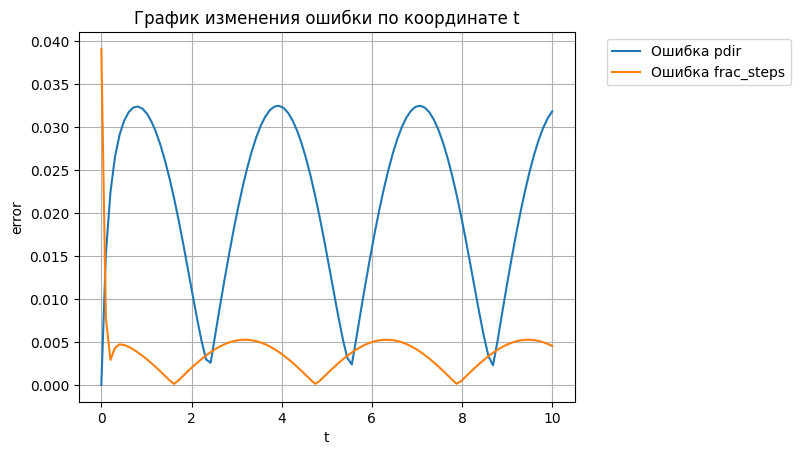

In [9]:
analytic_nodes = analytic(task.x0, task.x1, task.y0, task.y1, END_TIME, analytic_func, X_RES, Y_RES, T_RES)
pdir_nodes = pdir(task, X_RES, Y_RES, T_RES, END_TIME)
frac_steps_nodes = frac_steps(task, X_RES, Y_RES, T_RES, END_TIME)
draw_error(analytic_nodes, task.x0, task.x1, task.y0, task.y1, END_TIME, [pdir_nodes, frac_steps_nodes], ['pdir', 'frac_steps'])

##### Исследование зависимости погрешности от размеров сетки

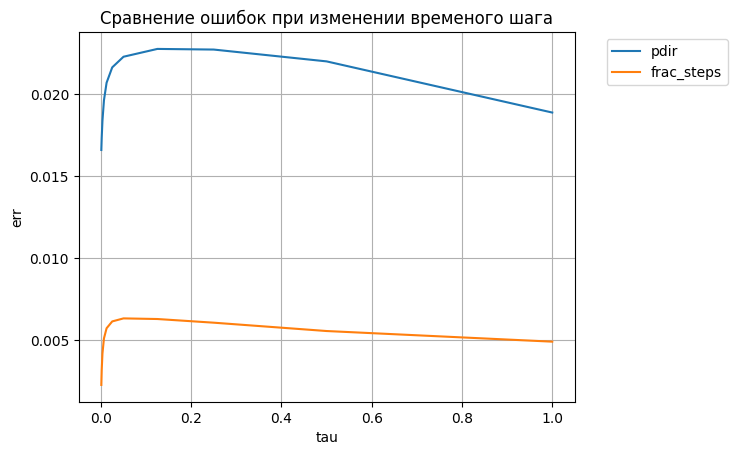

In [10]:
# Исследуем зависимость от tau при неизменном h
X_RES = 20
Y_RES = 20
END_TIME = 10
t_res_list = [10, 20, 40, 80, 200, 400, 800, 1500, 3000, 6000, 12000]

tau_list = [END_TIME / t_res for t_res in t_res_list]
pdir_v = []
frac_steps_v = []
for t_res in t_res_list:
    analytic_nodes = analytic(task.x0, task.x1, task.y0, task.y1, END_TIME, analytic_func, X_RES, Y_RES, t_res)
    pdir_nodes = pdir(task, X_RES, Y_RES, t_res, END_TIME)
    frac_steps_nodes = frac_steps(task, X_RES, Y_RES, t_res, END_TIME)
    get_err = lambda nodes: (np.mean(np.abs(analytic_nodes - nodes)))
    pdir_v.append(get_err(pdir_nodes))
    frac_steps_v.append(get_err(frac_steps_nodes))

plt.plot(tau_list, pdir_v, label = 'pdir')
plt.plot(tau_list, frac_steps_v, label = 'frac_steps')
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.title(f'Сравнение ошибок при изменении временого шага')
plt.xlabel('tau')
plt.ylabel('err')
plt.grid(True)
plt.show()

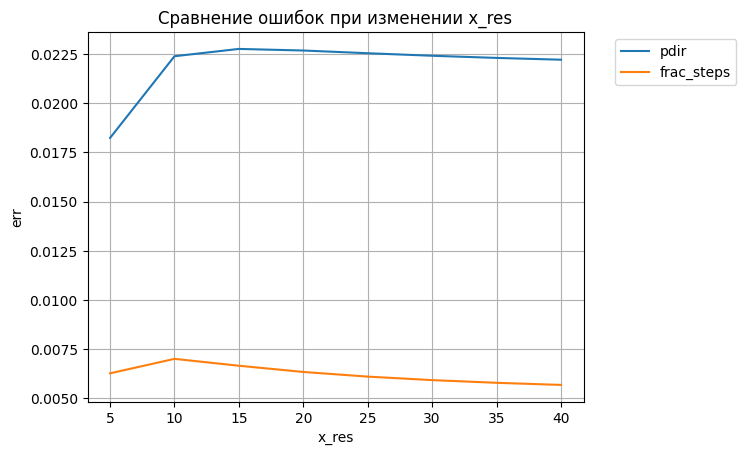

In [11]:
# Исследуем зависимость от x_res при неизменном tau
Y_RES = 20
T_RES = 100
END_TIME = 10
x_res_list = [x for x in range(5, 41, 5)]

pdir_v = []
frac_steps_v = []
for x_res in x_res_list:
    analytic_nodes = analytic(task.x0, task.x1, task.y0, task.y1, END_TIME, analytic_func, x_res, Y_RES, T_RES)
    pdir_nodes = pdir(task, x_res, Y_RES, T_RES, END_TIME)
    frac_steps_nodes = frac_steps(task, x_res, Y_RES, T_RES, END_TIME)
    get_err = lambda nodes: (np.mean(np.abs(analytic_nodes - nodes)))
    pdir_v.append(get_err(pdir_nodes))
    frac_steps_v.append(get_err(frac_steps_nodes))

plt.plot(x_res_list, pdir_v, label = 'pdir')
plt.plot(x_res_list, frac_steps_v, label = 'frac_steps')
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.title(f'Сравнение ошибок при изменении x_res')
plt.xlabel('x_res')
plt.ylabel('err')
plt.grid(True)
plt.show()

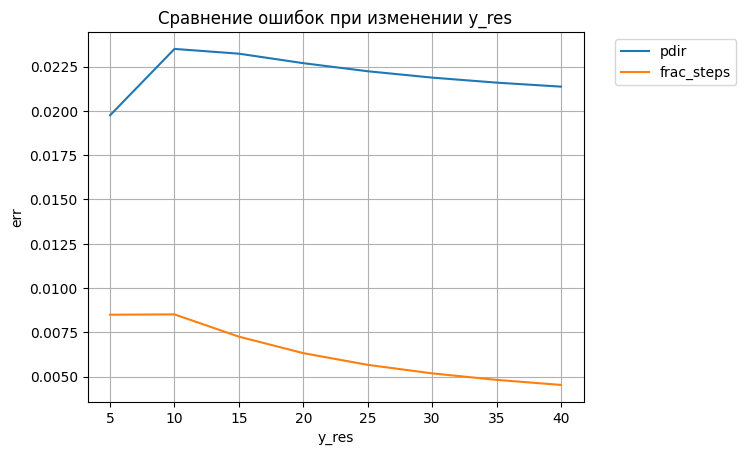

In [12]:
# Исследуем зависимость от y_res при неизменном tau
X_RES = 20
T_RES = 100
END_TIME = 10
y_res_list = [x for x in range(5, 41, 5)]

pdir_v = []
frac_steps_v = []
for y_res in y_res_list:
    analytic_nodes = analytic(task.x0, task.x1, task.y0, task.y1, END_TIME, analytic_func, X_RES, y_res, T_RES)
    pdir_nodes = pdir(task, X_RES, y_res, T_RES, END_TIME)
    frac_steps_nodes = frac_steps(task, X_RES, y_res, T_RES, END_TIME)
    get_err = lambda nodes: (np.mean(np.abs(analytic_nodes - nodes)))
    pdir_v.append(get_err(pdir_nodes))
    frac_steps_v.append(get_err(frac_steps_nodes))

plt.plot(x_res_list, pdir_v, label = 'pdir')
plt.plot(x_res_list, frac_steps_v, label = 'frac_steps')
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.title(f'Сравнение ошибок при изменении y_res')
plt.xlabel('y_res')
plt.ylabel('err')
plt.grid(True)
plt.show()

---

##### 4. Выводы

Как видно, метод дробных шагов показывает меньшую ошибку, чем метод переменных направлений.

При уменьшении tau - погрешность уменьшается. Кроме этого, при уменьшении размера пространственной сетки - погрешность так же уменьшается.